# Presentation Test Image evaluvation

In [1]:
pip install torch torchvision opencv-python scikit-image


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [8]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F

# Load images
ground_truth = cv2.imread('/content/HR merc.jpg')
model_processed = cv2.imread('/content/2x_upscaled_HR_merc.jpg')
competitor_processed = cv2.imread('/content/Remini_HR_upscaled.jpg')



In [9]:
# Convert images to RGB and resize to the same dimensions if necessary
ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB)
model_processed = cv2.cvtColor(model_processed, cv2.COLOR_BGR2RGB)
competitor_processed = cv2.cvtColor(competitor_processed, cv2.COLOR_BGR2RGB)

# Ensure the images have the same size
height, width = ground_truth.shape[:2]
model_processed = cv2.resize(model_processed, (width, height))
competitor_processed = cv2.resize(competitor_processed, (width, height))

# Compute PSNR
psnr_model = psnr(ground_truth, model_processed)
psnr_competitor = psnr(ground_truth, competitor_processed)

# Compute SSIM with a smaller win_size
ssim_model = ssim(ground_truth, model_processed, win_size=3, channel_axis=2)
ssim_competitor = ssim(ground_truth, competitor_processed, win_size=3, channel_axis=2)


In [10]:

# Preprocess images for VGG loss (Convert to Tensor)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

ground_truth_tensor = preprocess(ground_truth).unsqueeze(0)
model_processed_tensor = preprocess(model_processed).unsqueeze(0)
competitor_processed_tensor = preprocess(competitor_processed).unsqueeze(0)

# Load pretrained VGG16 model
vgg = models.vgg16(pretrained=True).features
vgg = vgg.eval()

# Extract features using VGG16
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Get features
ground_truth_features = get_features(ground_truth_tensor, vgg)
model_processed_features = get_features(model_processed_tensor, vgg)
competitor_processed_features = get_features(competitor_processed_tensor, vgg)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Compute VGG loss (L2 distance between feature maps)
def compute_vgg_loss(features1, features2):
    loss = 0
    for key in features1.keys():
        loss += F.mse_loss(features1[key], features2[key])
    return loss.item()

vgg_loss_model = compute_vgg_loss(ground_truth_features, model_processed_features)
vgg_loss_competitor = compute_vgg_loss(ground_truth_features, competitor_processed_features)

# Print results
print(f'PSNR (Our Model): {psnr_model:.4f}')
print(f'SSIM (Our Model): {ssim_model:.4f}')
print(f'VGG Loss (Our Model): {vgg_loss_model:.4f}')

print(f'PSNR (Competitor): {psnr_competitor:.4f}')
print(f'SSIM (Competitor): {ssim_competitor:.4f}')
print(f'VGG Loss (Competitor): {vgg_loss_competitor:.4f}')

PSNR (Our Model): 33.0409
SSIM (Our Model): 0.9435
VGG Loss (Our Model): 3.4595
PSNR (Competitor): 29.4230
SSIM (Competitor): 0.9427
VGG Loss (Competitor): 2.8433


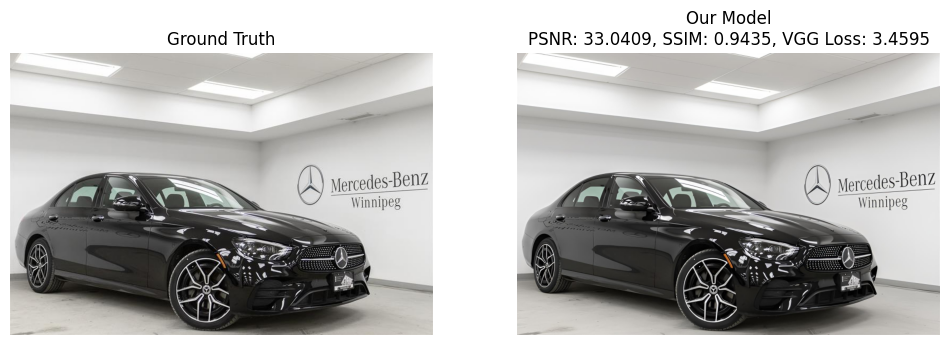

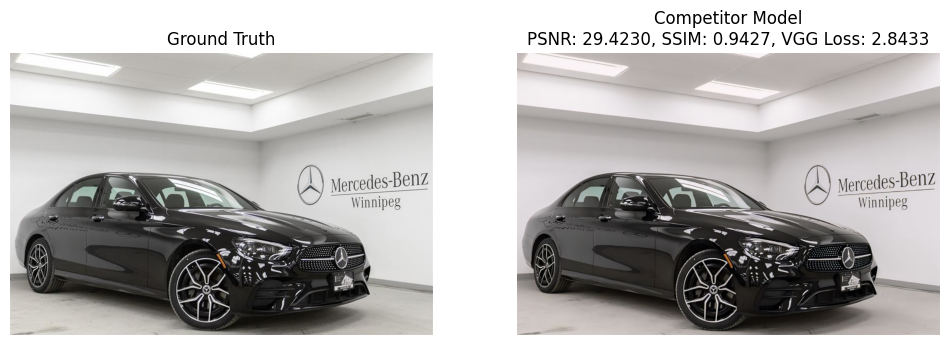

In [12]:
import matplotlib.pyplot as plt

# Display images and their corresponding results
def display_results(image1, image2, psnr_value, ssim_value, vgg_loss_value, title):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title(f'{title}\nPSNR: {psnr_value:.4f}, SSIM: {ssim_value:.4f}, VGG Loss: {vgg_loss_value:.4f}')
    plt.axis('off')

    plt.show()

# Display results for our model
display_results(ground_truth, model_processed, psnr_model, ssim_model, vgg_loss_model, 'Our Model')

# Display results for competitor's model
display_results(ground_truth, competitor_processed, psnr_competitor, ssim_competitor, vgg_loss_competitor, 'Competitor Model')
